### <center> This notebook has the postprocess of the raw downloaded glorys12v1 reanalysis and the following construction of the coastnorth/coastal hovmoller dataset

Since glorys12v1 is a heavy dataset only the coastnorth and coastal zone of western america was downloaded. The data was downloaded in chunks representative of some regions. In this notebook the raw data will be loaded and then transformed in a hovmoller type dataset with a meridional mean for the coastnorth zone and a zonal mean for the coastal zones. This process will reduce the dataset dimensions to a (time, space) dataset. Processed variables are: sea surface heights, ocean heat content defined as average temperature in the first 300m and sea surface temperature.

In [193]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

# Just for supressing an annoying warning
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

In [196]:
# Load glorys12v1 coastnorth and coastal masks (see create_masks.ipynb)
masks_GLORYS = xr.open_dataset('data/GLORYS_masks.nc')

def load_glorys(path):
    "quick function for opening preprocess glorys data"
    data = xr.open_mfdataset(path) # Load raw netcdf
    data = data.rename({'longitude':'lon', 'latitude':'lat'}) # Change some names
    data.coords['lon'] = xr.where(data.lon<0, data.lon+360, data.lon)
    data = data.sortby('lon', ascending=True)
    return data

# Load raw downloaded data
tropical = load_glorys('data/GLORYS12V1/HOVMOLLERS/data/tropical/*.nc')
camerica = load_glorys('data/GLORYS12V1/HOVMOLLERS/data/camerica/*.nc')
mexico   = load_glorys('data/GLORYS12V1/HOVMOLLERS/data/mexico/*.nc')
usa      = load_glorys('data/GLORYS12V1/HOVMOLLERS/data/usa/*.nc')
peru     = load_glorys('data/GLORYS12V1/HOVMOLLERS/data/peru/*.nc').sortby('lat', ascending=False)
chile    = load_glorys('data/GLORYS12V1/HOVMOLLERS/data/chile/*.nc').sortby('lat', ascending=False)

In [198]:
# Get the coastnorth hovmoller
tropical = tropical.sel(lon=slice(masks_GLORYS.lon.min(), masks_GLORYS.lon.max()))
tropical = tropical.where(masks_GLORYS.tropicalmask==1).mean('lat')
tropical = tropical.compute().dropna('lon')
tropical

<xarray.Dataset>
Dimensions:  (time: 7671, lon: 1698)
Coordinates:
  * lon      (lon) float32 140.0 140.1 140.2 140.2 ... 281.2 281.2 281.3 281.4
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2020-12-31T12:00:00
Data variables:
    T300     (time, lon) float32 27.36 27.36 27.37 27.38 ... 27.06 27.05 27.14
    zos      (time, lon) float32 0.7201 0.7204 0.7205 ... 0.3386 0.3447 0.3511
    sst      (time, lon) float32 30.23 30.24 30.25 30.26 ... 26.95 27.06 27.15

In [199]:
# Build coastal hovmoller
camerica = camerica.where(masks_GLORYS.coastmask_north==1).mean('lon').dropna('lat').compute()
mexico = mexico.where(masks_GLORYS.coastmask_north==1).mean('lon').dropna('lat').compute()
usa = usa.where(masks_GLORYS.coastmask_north==1).mean('lon').dropna('lat').compute()

peru = peru.where(masks_GLORYS.coastmask_south==1).mean('lon').dropna('lat').compute()
chile = chile.where(masks_GLORYS.coastmask_south==1).mean('lon').dropna('lat').compute()

In [200]:
# Concat and define final northern hemisphere hovmoller
coastnorth = xr.concat([camerica, mexico, usa], 'lat').drop_duplicates('lat').sortby('lat').drop('depth')
coastnorth

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 453)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2020-12-31T12:00:00
  * lat      (lat) float32 2.083 2.167 2.25 2.333 ... 39.75 39.83 39.92 40.0
Data variables:
    T300     (time, lat) float32 21.46 20.89 20.6 20.98 ... 10.4 10.37 10.35
    zos      (time, lat) float32 0.2166 0.216 0.215 ... 0.1244 0.1232 0.124
    sst      (time, lat) float32 26.41 26.45 26.47 26.48 ... 11.19 11.18 11.17

In [201]:
# Concat and define final southern hemisphere hovmoller
coastsouth = xr.concat([peru, chile], 'lat').drop_duplicates('lat').sortby('lat', ascending=False).drop('depth')
coastsouth

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 456)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2020-12-31T12:00:00
  * lat      (lat) float32 -2.083 -2.167 -2.25 -2.333 ... -39.83 -39.92 -40.0
Data variables:
    T300     (time, lat) float32 21.17 19.64 20.17 20.38 ... 11.72 11.66 12.03
    zos      (time, lat) float32 0.1541 0.1561 0.1566 ... 0.07904 0.08156
    sst      (time, lat) float32 24.84 24.66 24.68 24.73 ... 13.94 14.46 14.66

Now the data representative of the equatorial kelvin wave properties is in the "coastnorth" array, and the coastally trapped kelvin wave data is in the "coastnorth" and "coastsouth" array. Before saving this new data into disk some attributes and coordinates will be added. In particular it is of interest the distance along the hovmoller path as the spatial dimension, this distance must be built in spherical coordinates first for the coastnorth part (constant latitude) and then along the coast of america with changing latitudes and longitudes. In either way the "Haversine" formula will be used, because it allows to compute the distance between two points in spherical coordinates:

For two points $p_1=(\phi_1,\lambda_1)$ and $p_2=(\phi_2,\lambda_2)$, the haversine formula states that:
$$ hav(\frac{d}{R}) = hav(\phi_2-\phi_1)+cos(\phi_1)cos(\phi_2)hav(\lambda_2-\lambda_1) $$

Which allows to solve for the distance "d" between the two points as:
$$ d = 2R\cdot arcsin(\sqrt{hav(\theta)})$$

Or more explicitly:

$$ d = 2R \cdot arcsin(\sqrt{sin^2(\frac{\phi_2-\phi_1}{2})+cos(\phi_1)\cdot cos(\phi_2)\cdot sin^2(\frac{\lambda_2-\lambda_1}{2})}) $$


With this last formula a new dimension can be added to the dataset based on the coordinates of each pixel along the desired path. The latitudes and longitudes of all pixels will be added as a coordinates as well as an index or numerical position in the grid. Afterwards the distance in between points will be computed and the final dataset will be stored on disk with some attributes and metadata.

In [202]:
def haversine(p1,p2):
    """
    Given two points with lat,lon coordinates, compute the distance
    between those points on the surface of the sphere with the haversine formula
    Args:
        p1 (tuple): first point lat,lon
        p2 (tuple): last point lat,lon

    Returns:
        float: distance
    """
    lat1,lon1 = p1
    lat2,lon2 = p2

    lon1,lon2,lat1,lat2 = map(np.deg2rad, [lon1,lon2,lat1,lat2])

    dlon = lon2-lon1
    dlat = lat2-lat1

    a = np.sin(dlat/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    r = 6371
    return c*r

def distances(data, lon_name='lon', lat_name='lat'):
    """
    This function uses the haversine formula to build a 
    distance vector based on the latitude and longitude
    of the hovmoller data contained in xarray format.
    Args:
        data (xarray.Dataset): 
        Data set with the coastal or coastnorth hovmoller

    Returns:
        np.array: distances in km
    """
    distance = []
    for i in range(len(data[lon_name].values)-1):
        lon1,lat1 = data[lon_name].values[i], data[lat_name].values[i]
        lon2,lat2 = data[lon_name].values[i+1], data[lat_name].values[i+1]
        dist = haversine(p1=(lat2,lon2), p2=(lat1,lon1))
        distance.append(dist)
    distance = np.hstack([np.array([0]),np.array(distance)])
    distance = np.cumsum(distance)
    return distance
    

In [203]:
# Find longitude of each coastal american pixel
lon,lat = np.meshgrid(masks_GLORYS.lon,masks_GLORYS.lat)
coastnorthcoords   = pd.DataFrame((lon[0,:],np.zeros(len(lon[0,:]))), index=['lon','lat']).T
lonn = []
lons = []
for i in range(len(masks_GLORYS.lat)):
    try:
        x = masks_GLORYS.coastmask_north.where(masks_GLORYS.coastmask_north==1)
        x = x.isel(lat=i).dropna('lon')[-1].lon.item()
        lonn.append(x)
    except:
        lonn.append(np.nan)
        pass
    
    try:
        x = masks_GLORYS.coastmask_south.where(masks_GLORYS.coastmask_south==1)
        x = x.isel(lat=i).dropna('lon')[-1].lon.item()
        lons.append(x)
    except:
        lons.append(np.nan)
        pass
coastnorthcoords = pd.DataFrame((np.array(lonn),lat[:,0]),index=['lon','lat']).T.dropna()
coastsouthcoords = pd.DataFrame((np.array(lons),lat[:,0]),index=['lon','lat']).T.dropna()

coastnorthcoords.index = coastnorthcoords.lat
coastsouthcoords.index = coastsouthcoords.lat

coastnorthcoords = coastnorthcoords.loc[coastnorth.lat.values]
coastsouthcoords = coastsouthcoords.loc[coastsouth.lat.values]

In [204]:
# Assign the position along lons as a new spatial dimension/coordinate
tropical = tropical.assign_coords({'index':('lon',range(len(tropical.lon)))})
tropical = tropical.swap_dims({'lon':'index'}) # Make the position in the grid as the main coordinate
tropical = tropical.assign_coords({'lat':('index', np.zeros(len(tropical.index)))}) # Add latitudes

# Same but for coastnorth array
coastnorth = coastnorth.assign_coords({'index':('lat', 1+tropical.index[-1].item()+np.arange(len(coastnorth.lat)))}) # Add the position coordinate as the continuity of the coastnorth one
coastnorth = coastnorth.swap_dims({'lat':'index'})
coastnorth = coastnorth.assign_coords({'lon':('index', coastnorthcoords.lon.values)})

# Same but for coastsouth array
coastsouth = coastsouth.assign_coords({'index':('lat', 1+tropical.index[-1].item()+np.arange(len(coastsouth.lat)))}) # idem
coastsouth = coastsouth.swap_dims({'lat':'index'})
coastsouth = coastsouth.assign_coords({'lon':('index', coastsouthcoords.lon.values)})

In [205]:
# Assign distance as new coordinate for the tropical hovmoller
tropical = tropical.assign_coords({'distance':('index',distances(tropical))})
tropical = tropical.swap_dims({'index':'distance'})
tropical = tropical[['time','distance','lat','lon','index','zos','T300','sst']].drop_indexes(['distance','time'])

In [206]:
# Assign distance as new coordinate for the coastnorth hovmoller
gap = haversine((tropical.lat[-1].item(),tropical.lon[-1].item()),(coastnorth.lat[0].item(),coastnorth.lon[0].item())) # Distance between last pixel of coastnorth hovmoller and fisrst of coastnorth hovmoller
coastnorth = coastnorth.assign_coords({'distance':('index',tropical.distance[-1].item()+gap+distances(coastnorth))})
coastnorth = coastnorth.swap_dims({'index':'distance'})
coastnorth = coastnorth[['time','distance','lat','lon','index','zos','T300','sst']].drop_indexes(['distance','time'])

In [207]:
# Assign distance as new coordinate for the coastsouth hovmoller
gap = haversine((tropical.lat[-1].item(),tropical.lon[-1].item()),(coastsouth.lat[0].item(),coastsouth.lon[0].item())) # Distance between last pixel of coastnorth hovmoller and fisrst of coastnorth hovmoller
coastsouth = coastsouth.assign_coords({'distance':('index',tropical.distance[-1].item()+gap+distances(coastsouth))})
coastsouth = coastsouth.swap_dims({'index':'distance'})
coastsouth = coastsouth[['time','distance','lat','lon','index','zos','T300','sst']].drop_indexes(['distance','time'])

Now the data is ready with the correct coordinates and dimensions: a time dimension and spatial dimensions in relation to the geographic latitude, longitude along with a numerical index and the distance (in km) of the coastnorth/coast pathway. With this done now some attributes and metadata will be added to the dataset and variables and then the data will be finally stored on disk.

In [184]:
dummy = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/domain.nc') # dummy raw glorys dataset with some attributes

# Global attributes
tropical_attrs   = {'name':'Tropical Hovmoller of GLORYS12V1 Reanalysis',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'GLORYS12V1 average along the tropical band (2°S - 2°N)',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}
coastnorth_attrs = {'name':'Coastal Hovmoller of GLORYS12V1 Reanalysis for the North East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'GLORYS12V1 average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}
coastsouth_attrs = {'name':'Coastal Hovmoller of GLORYS12V1 Reanalysis for the South East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'GLORYS12V1 average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}

# Common variable attributes
zos_attrs        = {'long_name':'Sea surface height above geoid',
                    'short_name':'zos',
                    'units':'m'}
sst_attrs        = {'long_name':'Sea surface temperature',
                    'short_name':'sst',
                    'units':'degC'}
ohc_attrs        = {'long_name':'Ocean Heat Content defined as the mean temperature of the first 300 meters',
                    'short_name':'T300',
                    'units':'degC'}
lon_attrs        = dummy.longitude.attrs
lat_attrs        = dummy.latitude.attrs
time_attrs       = dummy.time.attrs
index_attrs      = {'long_name':'Position along the spatial dimension of the hovmoller grid',
                    'short_name':'index',
                    'units':'(-)'}
distance_attrs   = {'long_name':'Distance along the spatial dimension of the hovmoller grid',
                    'short_name':'distance',
                    'units':'km'}

In [213]:
# Assign attributes 
tropical.attrs          = tropical_attrs
tropical.zos.attrs      = zos_attrs
tropical.sst.attrs      = sst_attrs
tropical.T300.attrs     = ohc_attrs
tropical.lon.attrs      = lon_attrs
tropical.lat.attrs      = lat_attrs
tropical.index.attrs    = index_attrs
tropical.distance.attrs = distance_attrs

coastnorth.attrs          = coastnorth_attrs
coastnorth.zos.attrs      = zos_attrs
coastnorth.sst.attrs      = sst_attrs
coastnorth.T300.attrs     = ohc_attrs
coastnorth.lon.attrs      = lon_attrs
coastnorth.lat.attrs      = lat_attrs
coastnorth.index.attrs    = index_attrs
coastnorth.distance.attrs = distance_attrs

coastsouth.attrs          = coastsouth_attrs
coastsouth.zos.attrs      = zos_attrs
coastsouth.sst.attrs      = sst_attrs
coastsouth.T300.attrs     = ohc_attrs
coastsouth.lon.attrs      = lon_attrs
coastsouth.lat.attrs      = lat_attrs
coastsouth.index.attrs    = index_attrs
coastsouth.distance.attrs = distance_attrs

In [221]:
# Save data into disk
tropical.to_netcdf('./data/HOVMOLLERS/GLORYS_hovmoller_tropical_2000-2020.nc')
coastnorth.to_netcdf('./data/HOVMOLLERS/GLORYS_hovmoller_coastnorth_2000-2020.nc')
coastsouth.to_netcdf('./data/HOVMOLLERS/GLORYS_hovmoller_coastsouth_2000-2020.nc')

Text(0, 0.5, 'Tropical - South America Coast')

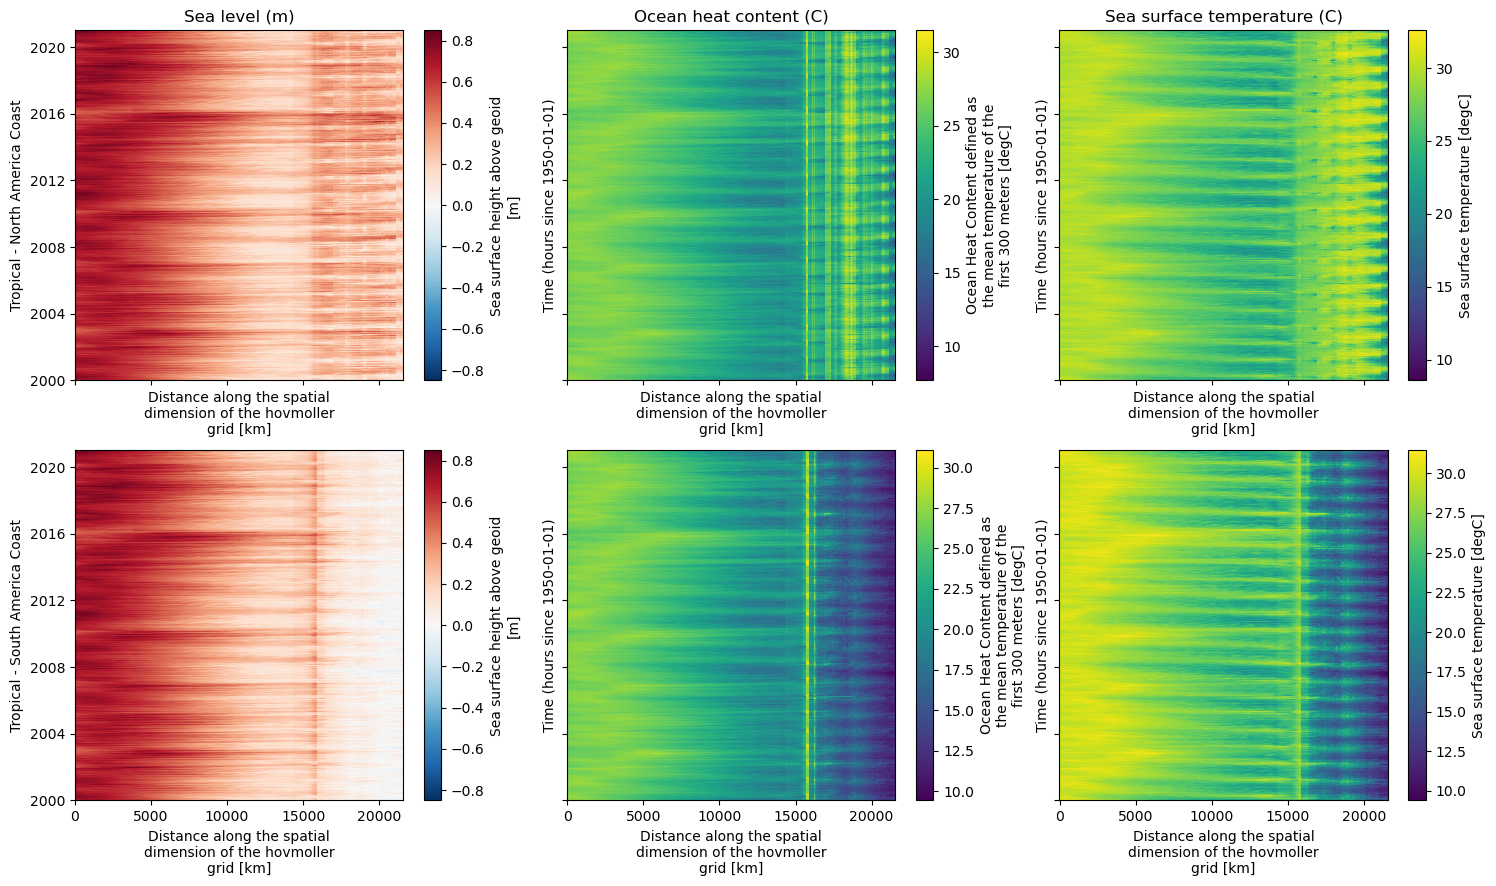

In [215]:
# Quicklook to the hovmollers
fig, ax = plt.subplots(2,3, figsize=(18,10), dpi=100, facecolor='w',
                       sharex=True, sharey=True)

xr.concat([tropical,coastnorth], 'distance').zos.plot(ax=ax[0,0])
xr.concat([tropical,coastnorth], 'distance').T300.plot(ax=ax[0,1])
xr.concat([tropical,coastnorth], 'distance').sst.plot(ax=ax[0,2])

xr.concat([tropical,coastsouth], 'distance').zos.plot(ax=ax[1,0])
xr.concat([tropical,coastsouth], 'distance').T300.plot(ax=ax[1,1])
xr.concat([tropical,coastsouth], 'distance').sst.plot(ax=ax[1,2])

ax[0,0].set_title('Sea level (m)')
ax[0,1].set_title('Ocean heat content (C)')
ax[0,2].set_title('Sea surface temperature (C)')

ax[0,0].set_ylabel('Tropical - North America Coast')
ax[1,0].set_ylabel('Tropical - South America Coast')